# Programming Exercise 5: scikit-learn exercise

## Introduction

In this exercise we will investigate the [`scikit-learn`](https://scikit-learn.org/stable/) library. We will start by predicting breast cancer, before we continue to predict digits in the MNIST dataset. The remaining exercises in this course will to some extent resemble tutorials, compared to the previous exercises. That is, much of the mathematics are skipped, and we will now primarily look at software packages and examples of empoying machine learning.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np
np.random.seed(42)  # Set the global random seed to make reproducible experiments (scikit-learn also use this)

# Efficient and easy handling of data
import pandas as pd

# Python plotting library
import matplotlib.pyplot as plt

# Plotting tool based on matplotlib for fast visualization of data
import seaborn as sns

# Load function to plot confusion matrices
from utils import plot_confusion_matrix
 
# Machine learning tools
from sklearn.datasets import load_digits                     # MNIST dataset
from sklearn.preprocessing import StandardScaler             # Feature scaling
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance
from sklearn.metrics import confusion_matrix                 # Confusion matrix
from sklearn.metrics import accuracy_score

# Time training and prediction time
from time import time

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# Autoreload every time a cell is run
%load_ext autoreload
%autoreload 2

## 1 Predicting breast cancer
In this part of the exercise we will look at breast cancer prediction using various machine learning classifiers. We will start by loading the data into Pandas to investigate them, before they are loaded into NumPy to follow the line of the previous exercises. Then we will try a variety of classifiers, compare them, and discuss pros/cons.

### 1.1 Investigate the data

This part will demonstrate some of the advantages whem employing Pandas and Seaborn to investigate your data. We have not been using these libraries in this course, as the main emphasis should be on machine learning. However, if you would like to master a very strong toolbox for applying machine learning using Python, it is advised to learn how to use these libraries. There is no code to be implemented in this part of the exercise, which should rather be seen as a demonstration of how these libraries can help you gain an overview of your data.

In [2]:
# Load the data into Pandas (df is an abbreviation for dataframe)
df_cancer = pd.read_csv(os.path.join('Data', 'breast_cancer.csv'))

# Show the first 5 examples, including values for all input features.
df_cancer.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


We now have an overview of the input data. However, there are two columns, 'id' and 'Unnamed: 32' which does not contain valuable information, and will therefore be dropped.

In [3]:
# Remove unnecessary columns
df_cancer.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

Now let us look at the number of samples in the two classes.

In [4]:
# Count number of samples in each class
total = df_cancer['diagnosis'].count() # Count total number of samples
malignant = df_cancer[df_cancer['diagnosis'] == "M"]['diagnosis'].count() # Count how many has diagnosis = M (for malignent)
print("Malignant: ", malignant)
print("Benign: ", total - malignant)

Malignant:  212
Benign:  357


So the classes are not perfectly balanced (ie. they do not have the same number of samples in each class). However, they are not not skewed enough for us to take further action in this exercise. If you would like to see an example on how to deal with imbalanced classes when training an SVM classifier, look here: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html. 

Pandas can automatically generate statistics based on the data in the dataframe. In the following cells we will quickly look at statistics for the entire dataset, then statistics for the malignent cases, and finally statistics for the benign cases.

In [5]:
# Generate statistics for entire dataset
df_cancer.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# Generate statistics for malignent cases
df_cancer[df_cancer['diagnosis'] == "M"].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
std,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,0.027638,0.007573,...,4.283569,5.434804,29.457055,597.967743,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553
min,10.950000,10.380000,71.900000,361.600000,0.073710,0.046050,0.023980,0.020310,0.130800,0.049960,...,12.840000,16.670000,85.100000,508.100000,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040
25%,15.075000,19.327500,98.745000,705.300000,0.094010,0.109600,0.109525,0.064620,0.174050,0.056598,...,17.730000,25.782500,119.325000,970.300000,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302
50%,17.325000,21.460000,114.200000,932.000000,0.102200,0.132350,0.151350,0.086280,0.189900,0.061575,...,20.590000,28.945000,138.000000,1303.000000,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600
75%,19.590000,23.765000,129.925000,1203.750000,0.110925,0.172400,0.203050,0.103175,0.209850,0.067075,...,23.807500,32.690000,159.800000,1712.750000,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625
max,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500


In [7]:
# Generate statistics for bening cases
df_cancer[df_cancer['diagnosis'] == "B"].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
std,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,0.024807,0.006747,...,1.981368,5.493955,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.051850,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210
25%,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,0.158000,0.058530,...,12.080000,19.580000,78.270000,447.100000,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090
50%,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,0.171400,0.061540,...,13.350000,22.820000,86.920000,547.400000,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120
75%,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,0.189000,0.065760,...,14.800000,26.510000,96.590000,670.000000,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410
max,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,0.274300,0.095750,...,19.820000,41.780000,127.100000,1210.000000,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600


We already see some differences from these statistics. For instance, the mean value of 'radius_mean' differ quite significantly between the malignent and benign cases (17.46 and 12.15 respectively). So we start to get a brief understanding of the data. To go a step further, we will do a scatterplot matrix using the Seaborn library. You can read more about scatteplot matrices here: https://seaborn.pydata.org/examples/scatterplot_matrix.html.

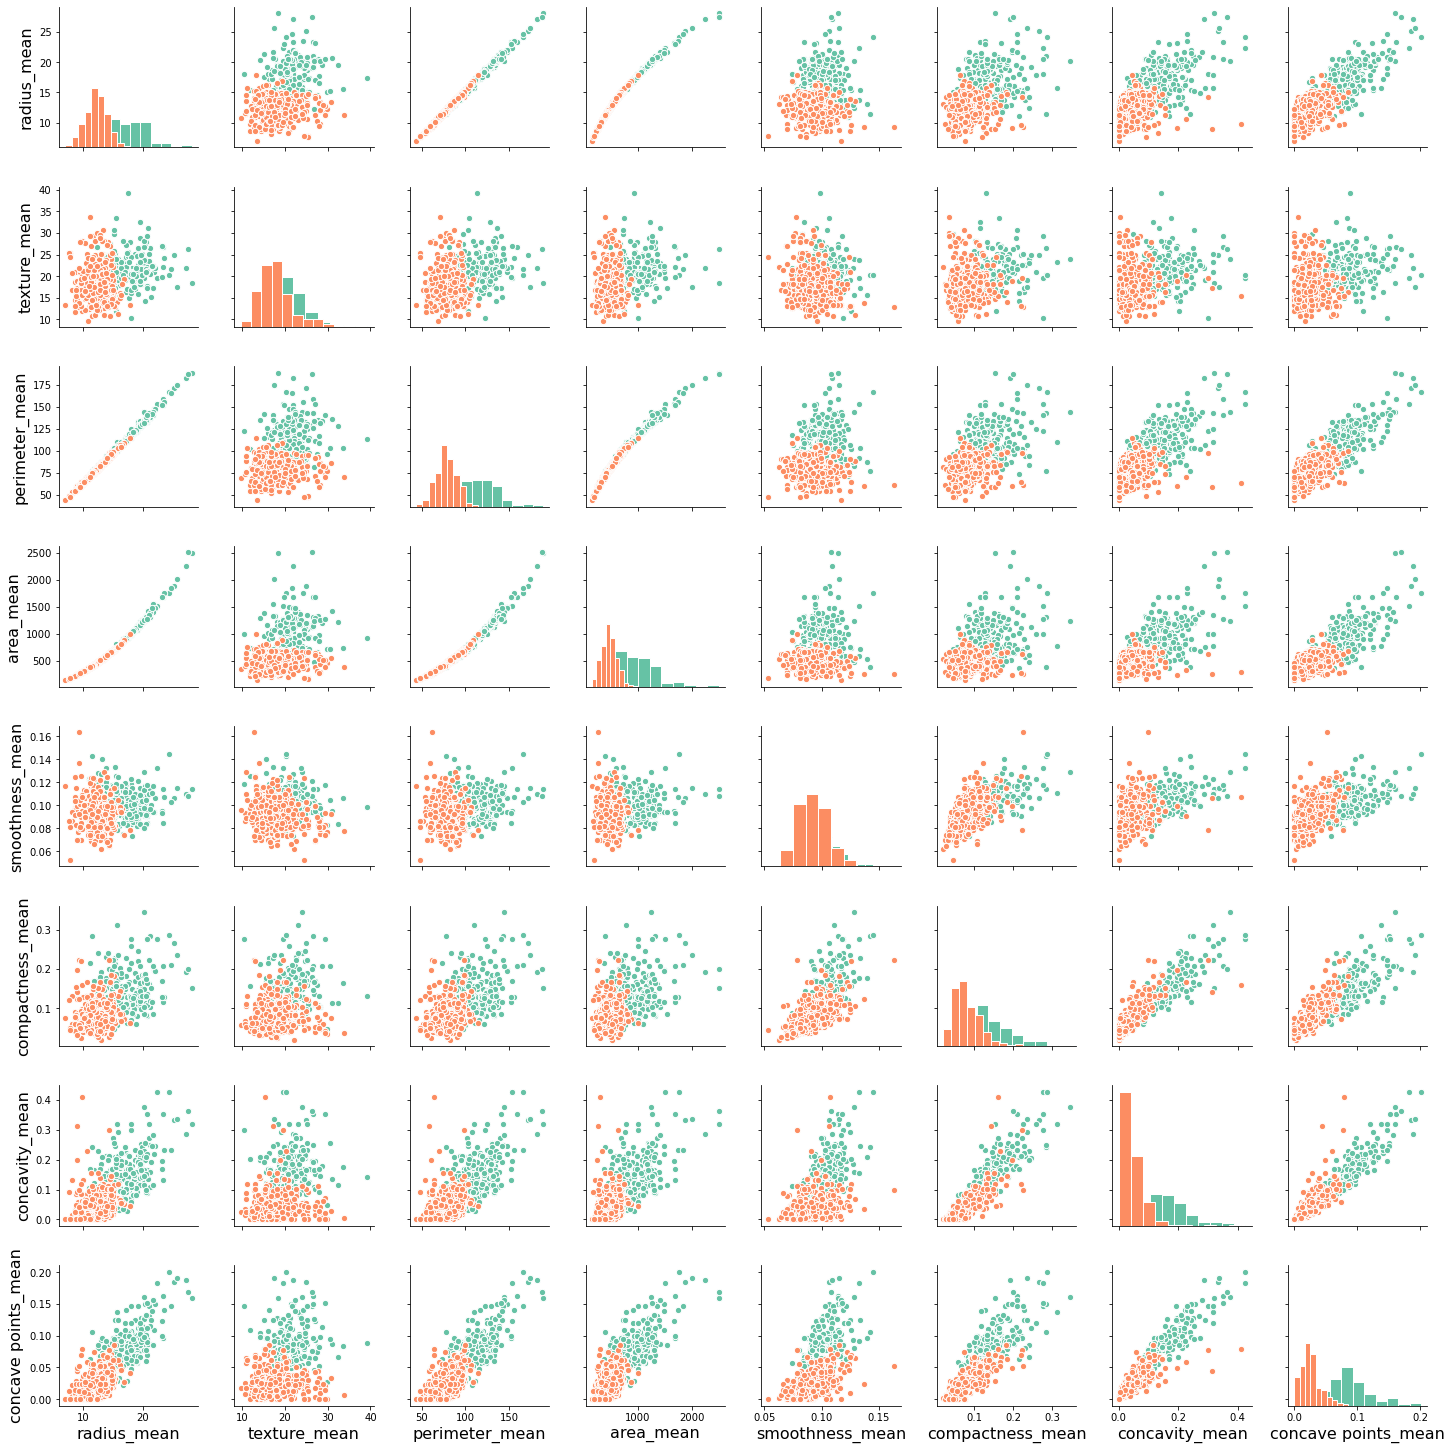

In [8]:
with sns.plotting_context(rc={"axes.labelsize":16}):  # Temporarily change the font size for seaborn plots
    # Select the first 8 columns 
    df_cancer_plot_features = df_cancer.iloc[:, :9]
    
    # Create pairgrid with hue set to show the two different diagnoses
    g = sns.PairGrid(df_cancer_plot_features, hue="diagnosis", palette="Set2")
    g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

    # Show histograms of the data on the diagonal and plot the figure
    g = g.map_diag(plt.hist, edgecolor="w")
    plt.show()

This looks promising for a classifier to perform well. However, we do see some redundant features, where the 'radius_mean' and 'perimeter_mean' are simply scaled versions of each other (which makes perfect sense). Having both of these features in the dataset might be relevant to a doctor, but should be avoided when employing machine learning classifiers. In this case, we will only remove the 'perimeter_mean' features. It should be noted that this would automatically be fixed by employing dimensionality reduction, which we have completely skipped in this course, as we needed to save time such that we could get to deep learning. However, Lecture 14 and Exercise 7 from Andrew Ng's Machine learning course cover dimensionality reduction, if you would like to investigate it further.

In [9]:
# Remove redundant features
df_cancer.drop(['perimeter_mean'], axis=1, inplace=True)

In Seaborn, we can also generate correlation matrices. Let us do this for the first 16 columns. 

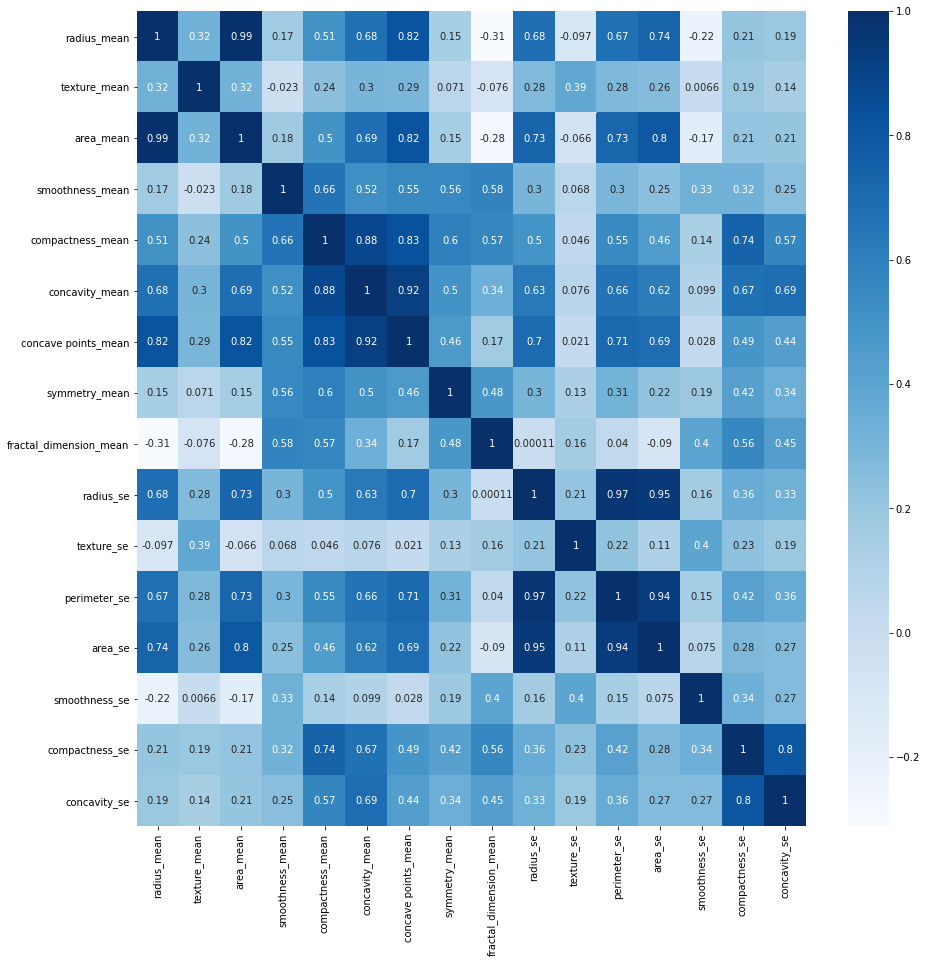

In [10]:
# Select the first 16 columns 
df_cancer_plot_features = df_cancer.iloc[:, :17]

# Calculate correlation coefficients
# (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)
df_cancer_corr = df_cancer_plot_features.corr()

# Create figure and plot the correlation coefficients as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df_cancer_corr, cmap="Blues", annot=True)
plt.show()

### 1.2 Pre-process the data

Now we have a reasonably good overview of the data we are working with. Before we can start training classifiers, however, we need to map the two classes to numerical values

In [8]:
# Assign the classes numerical values
df_cancer['diagnosis'] = df_cancer['diagnosis'].map({'M':1,'B':0}) # Sets M = 1 and B = 0

Now let us go back to using numpy for the remainder of the breast cancer exercise

In [9]:
array = df_cancer.values

# Define the independent variables as features.
X = array[:,1:]

# Define the target (dependent) variable as labels.
y = array[:,0]

# Store the class names for later to plot results
class_names = ['Malignent', 'Benign']

Is is important to split the data into training and test data. To do this, look at the documentation for the 'train_test_split()' function in scikit learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html. Now provide the function in the cell below with the arguments to make a 70/30 split between train and test data respectively. Note that the random state was already set in the top of the notebook, where we defined random seed for the NumPy library, which is also what scikit learn uses for random generators.

In [10]:
# ====================== YOUR CODE HERE =======================

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# =============================================================

# Check the split by printing the shape of each set.
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape:  " + str(X_test.shape))
print("y_test shape:  " + str(y_test.shape))

X_train shape: (398, 30)
y_train shape: (398,)
X_test shape:  (171, 30)
y_test shape:  (171,)


The following function evaluates a classifier. It first fits the classifier to the training data, before it uses the trained classifier to classify the test data. If feature scaling is desired, this will be carried out as the first step.

In [11]:
def evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False):
    """
    This function evaluates a classifier. It measure training and prediction time, and 
    prints performance metrics and a confustion matrix. The returned classifier and 
    scaler are fitted to the training data, and can be used to predict new samples.
    """
    
    # Perform feature scaling
    scaler = StandardScaler()  # Scale to mean = 0 and std_dev = 1
    if feature_scale:
        # ====================== YOUR CODE HERE =======================

        X_train = scaler.fit_transform(X_train)  # Fit to training data and then scale training data
        X_test = scaler.transform(X_test)  # Scale test data based on the scaler fitted to the training data

        # =============================================================
        
    # Store the time so we can calculate training time later
    t0 = time()

    # Fit the classifier on the training features and labels
    # ====================== YOUR CODE HERE =======================

    clf.fit(X_train, y_train)

    # =============================================================
    
    # Calculate and print training time
    print("Training time:", round(time()-t0, 4), "s")

    # Store the time so we can calculate prediction time later
    t1 = time()
    
    # Use the trained classifier to classify the test data
    # ====================== YOUR CODE HERE =======================

    predictions = clf.predict(X_test)

    # =============================================================
    
    # Calculate and print prediction time
    print("Prediction time:", round(time()-t1, 4), "s")

    # Evaluate the model
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    report = classification_report(y_test, predictions, target_names=class_names)

    # Print the reports
    print("\nReport:\n")
    print("Train accuracy: {}".format(round(train_accuracy, 4)))
    print("Test accuracy: {}".format(round(test_accuracy, 4)))
    print("\n", report)
    
    # Plot confusion matrices
    cnf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cnf_matrix, classes=class_names)
    
    # Return the trained classifier to be used on future predictions
    return clf, scaler

Now let us try the implemented function by evaluating logistic regression.

Training time: 0.108 s
Prediction time: 0.0004 s

Report:

Train accuracy: 0.9598
Test accuracy: 0.9766

               precision    recall  f1-score   support

   Malignent       0.98      0.98      0.98       108
      Benign       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



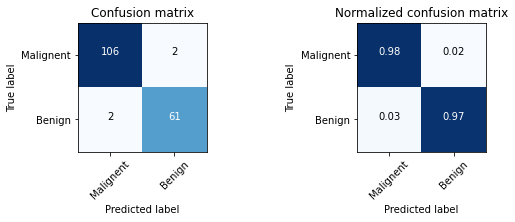

In [12]:
from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
clf = LogisticRegression(solver='newton-cg')

# Evaluate classifier without feature scaling
clf_trained, _ = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False)

You should get accuracies of 0.9548 and 0.9708 for the train and test set respectively. Those are already very good results. Note that the normalized confusion matrix is normalized with respect to each row (each true label).

Let us test the classifier evaluation function when employing feature scaling.

Training time: 0.0079 s
Prediction time: 0.0003 s

Report:

Train accuracy: 0.9874
Test accuracy: 0.9825

               precision    recall  f1-score   support

   Malignent       0.99      0.98      0.99       108
      Benign       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



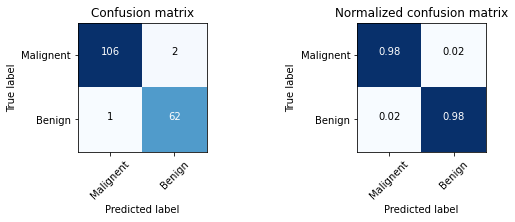

In [16]:
# Instantiate classifier.
clf = LogisticRegression(solver='newton-cg')

# Evaluate classifier with feature scaling
clf_trained, scaler_fitted = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

You should get accuracies of 0.9874 and 0.9825 for the train and test set respectively.

### 1.3 Evaluate classifiers
In this section you will try a variety of classifiers. Try looking at the following link for inspiration: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html. It contains a comparison of various classifiers, with decision boundaries plotted to provide some intuition as to how they work.

As you go along in this exercise, remember to interpret the results, and see if you can intuitively understand what they mean.

#### 1.3.1 Decision Tree Classifier

Training time: 0.0052 s
Prediction time: 0.0005 s

Report:

Train accuracy: 1.0
Test accuracy: 0.9474

               precision    recall  f1-score   support

   Malignent       0.98      0.94      0.96       108
      Benign       0.90      0.97      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



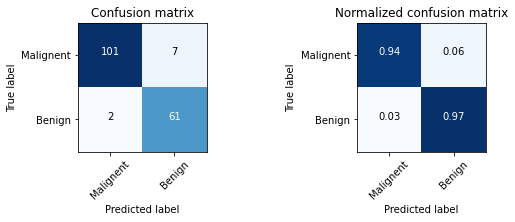

In [17]:
from sklearn.tree import DecisionTreeClassifier              

# Instantiate and evaluate classifier
clf = DecisionTreeClassifier()
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=False)

#### 1.3.2 Linear Support Vector Machine (SVM)

Training time: 0.0028 s
Prediction time: 0.0007 s

Report:

Train accuracy: 0.9899
Test accuracy: 0.9766

               precision    recall  f1-score   support

   Malignent       0.98      0.98      0.98       108
      Benign       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



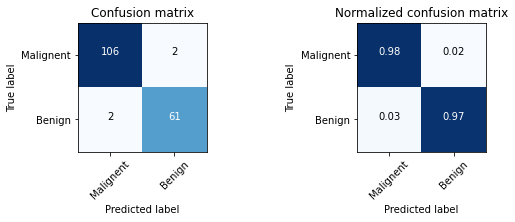

In [13]:
from sklearn.svm import SVC   

# Instantiate and evaluate classifier
clf = SVC(kernel='linear')
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

#### 1.3.3 Kernel based Support Vector Machine (SVM)

Training time: 0.0029 s
Prediction time: 0.0008 s

Report:

Train accuracy: 0.9874
Test accuracy: 0.9766

               precision    recall  f1-score   support

   Malignent       0.98      0.98      0.98       108
      Benign       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



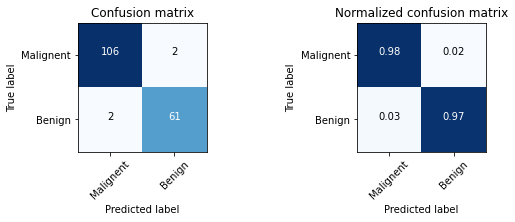

In [14]:
# Instantiate and evaluate classifier
clf = SVC(kernel='rbf')
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

#### 1.3.4 Multilayer Perceptron (MLP) - also referred to as fully connected neural network

Training time: 0.1813 s
Prediction time: 0.001 s

Report:

Train accuracy: 0.9849
Test accuracy: 0.9825

               precision    recall  f1-score   support

   Malignent       0.98      0.99      0.99       108
      Benign       0.98      0.97      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



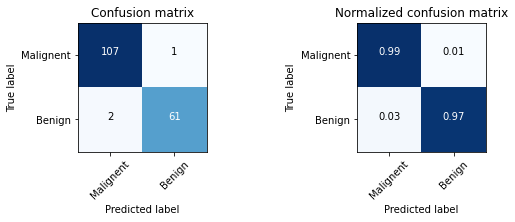

In [15]:
from sklearn.neural_network import MLPClassifier

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(25, 25))  # See what happens when you change random state
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

Now try your own classifiers, and remember to compare the relevant metrices. For instance, a high recall value for the malignent tumors are extremely important in the case of cancer prediction. If you are not unsure as to why this is, try looking here: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9.

### 1.4 Brief look at k-fold cross-validation

We have not covered k-fold cross-validation in these exercises, although it is a highly relevant, especially if you have small datasets. If you are unsure of how this works, take a look here: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation. Regarding how it is performed in scikit-learn, look here: https://scikit-learn.org/stable/modules/cross_validation.html. Below is an example of how straight-forward it is to employ 10-fold cross-validation on the breast cancer dataset using scikit-learn.

In [16]:
from sklearn.model_selection import cross_val_score

# Use 10-fold cross-validation to evaluate logistic regression on our dataset
clf = LogisticRegression(solver='newton-cg')
scores = cross_val_score(clf, X, y, cv=10)  # Remember to provide the entire dataset

print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.9543 (+/- 0.0475)


Looking at the results from the 10-fold cross-validation, we can conclude that logistic regression results in a high accuracy, and that for the ten classifiers we trained, the accuracy remained consistent. 

One additional note regarding scikit-learn is on hyperparameter optimization. We will not investigate it here, but if you want to, e.g., find the optimal number of neurons in the hidden layer of your neural network classifier, scikit-learn has built-in methods to help you. Take a look here: https://scikit-learn.org/stable/modules/grid_search.html.

A final note regarding the possibilities in scikit-learn should be on pipelining. This is a method for coupling several classifiers, or pre-processing and classification steps, into one single function call. If you would like to learn more, take a look here: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976.

## 2 MNIST Classification
### 2.1 Get the data

Load the MNIST data from Exercise 4. 

In [17]:
# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

print(X.shape)
print(y.shape)
# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Define class names as 'Class 0', 'Class 1' ... 'Class 9'
class_names = []
for i in range(10):
    class_names.append('Class ' + str(i))

(5000, 400)
(5000,)


### 2.2 Evaluate various classifiers
Let us evaluate several classifiers on the MNIST dataset. Remember to pay attention to the test scores, and to the training and prediction times. Often, we do not care too much about a high training time, as it is not critical once the classifier is deployed for usage. A high prediction time can be very computationally expensive if you have thousands of users which employ your classifier.

#### 2.2.1 Neural network from Exercise 4

Let us try recreating the neural networks architecture which we made in Exercise 4 using scikit-learn.

Training time: 0.6329 s
Prediction time: 0.0019 s

Report:

Train accuracy: 1.0
Test accuracy: 0.9153

               precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97       152
     Class 1       0.93      0.99      0.95       150
     Class 2       0.91      0.89      0.90       161
     Class 3       0.93      0.89      0.91       152
     Class 4       0.93      0.90      0.92       147
     Class 5       0.93      0.89      0.91       152
     Class 6       0.88      0.94      0.91       155
     Class 7       0.88      0.92      0.90       132
     Class 8       0.92      0.87      0.89       156
     Class 9       0.86      0.90      0.88       143

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



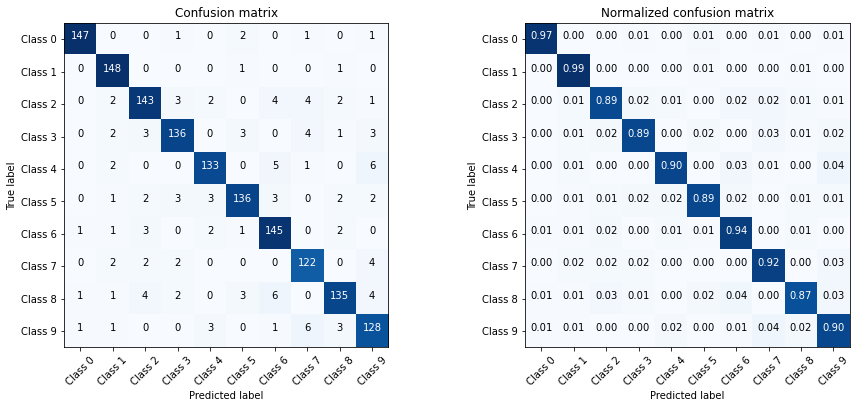

In [18]:
# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=1, hidden_layer_sizes=(25, 10))
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

We see that the test set accuracy is quite low, compared to the training set accuracy. Try finding a good 'alpha' parameter (L2 regularization parameter) to maximize the test set accuracy.

#### 2.2.2 Kernel based SVM
Let us now try a kernel based SVM. Remember how we can use the One-vs-Rest method to use binary classifiers in multi-class problems.

Training time: 12.7195 s
Prediction time: 3.3696 s

Report:

Train accuracy: 0.978
Test accuracy: 0.902

               precision    recall  f1-score   support

     Class 0       0.94      0.99      0.96       152
     Class 1       0.91      0.98      0.95       150
     Class 2       0.89      0.88      0.89       161
     Class 3       0.94      0.87      0.90       152
     Class 4       0.94      0.89      0.92       147
     Class 5       0.91      0.91      0.91       152
     Class 6       0.92      0.91      0.92       155
     Class 7       0.77      0.93      0.84       132
     Class 8       0.92      0.80      0.86       156
     Class 9       0.87      0.87      0.87       143

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



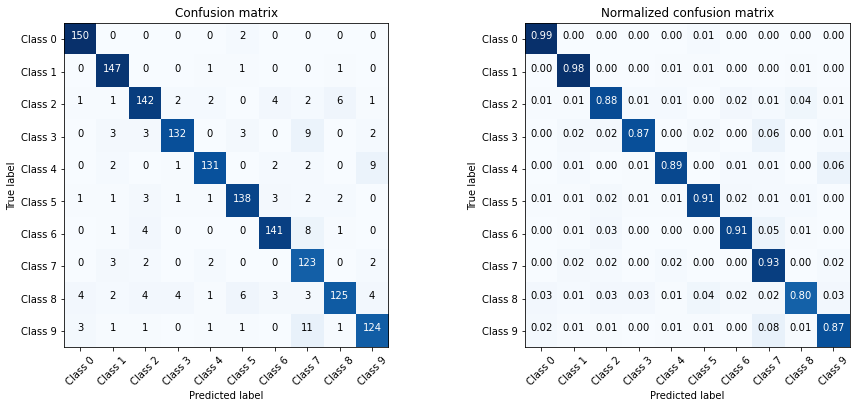

In [19]:
from sklearn.multiclass import OneVsRestClassifier

# Instantiate and evaluate classifier
clf = OneVsRestClassifier(SVC(kernel='rbf', gamma='scale'))
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

#### 2.2.3 Logistic regression

Training time: 2.3567 s
Prediction time: 0.0062 s

Report:

Train accuracy: 0.9849
Test accuracy: 0.8727

               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97       152
     Class 1       0.90      0.97      0.93       150
     Class 2       0.87      0.83      0.85       161
     Class 3       0.84      0.84      0.84       152
     Class 4       0.86      0.89      0.87       147
     Class 5       0.83      0.82      0.83       152
     Class 6       0.91      0.92      0.92       155
     Class 7       0.88      0.91      0.90       132
     Class 8       0.88      0.76      0.82       156
     Class 9       0.79      0.83      0.81       143

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



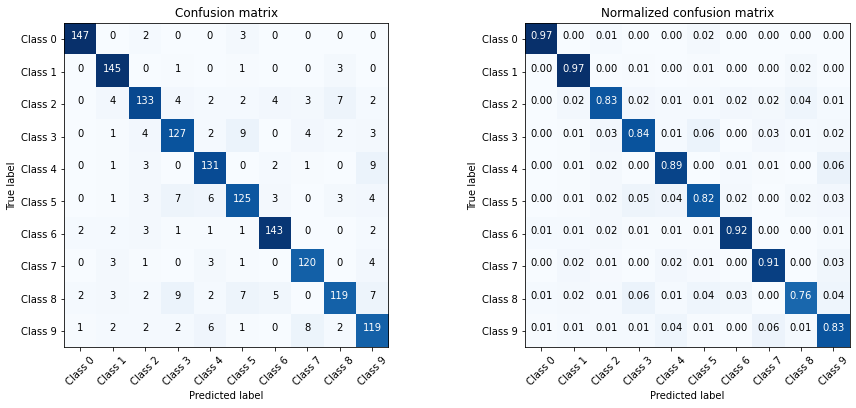

In [20]:
# Instantiate and evaluate classifier
clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_trained = evaluate_classifer(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

We see how easy it is to train various classifiers, and we see how important it is to always evaluate our classifiers on a test dataset.

### 2.3 Full size MNIST dataset (you need TensorFlow and Keras)

The MNIST dataset from Exercise 4 only contain 5.000 samples, and each sample is only 20x20 pixels. The full size MNIST dataset contains 60.000 training samples and 10.000 test samples, with each sample being 28x28 pixels. 

In [21]:
import keras
from keras.datasets import mnist

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

60000 train samples
10000 test samples


Now try varying the number of samples you want to use, and see how this affects the training time. If you want to compare the training time here with the one from the neural network trained using the MNIST data from Exercise 4 in section 2.2.1, then use 3500 training samples and 1500 test samples. This is equivalent to the 70/30 split on the 5000 total number of samples we used at that point. Doing this will let you compare the training time when using 20x20 pixel images and 28x28 pixels images.

Then try to find the optimally performing MLP classifier on the MNIST data. Vary alpha, hidden_layer_sizes, and try looking up the documentation for the MLPClassifier to see if there are more interesting things to adjust.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training time: 81.8243 s
Prediction time: 0.0082 s

Report:

Train accuracy: 0.9993
Test accuracy: 0.948

               precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98       126
     Class 1       0.98      0.98      0.98       179
     Class 2       0.93      0.95      0.94       172
     Class 3       0.95      0.95      0.95       154
     Class 4       0.96      0.93      0.95       167
     Class 5       0.95      0.92      0.94       137
     Class 6       0.95      0.95      0.95       131
     Class 7       0.95      0.94      0.95       150
     Class 8       0.92      0.92      0.92       139
     Class 9       0.92      0.92      0.92       144

    accuracy                           0.95      1499
   macro avg       0.95      0.95      0.95      1499
weighted avg       0.95      0.95      0.95      1499



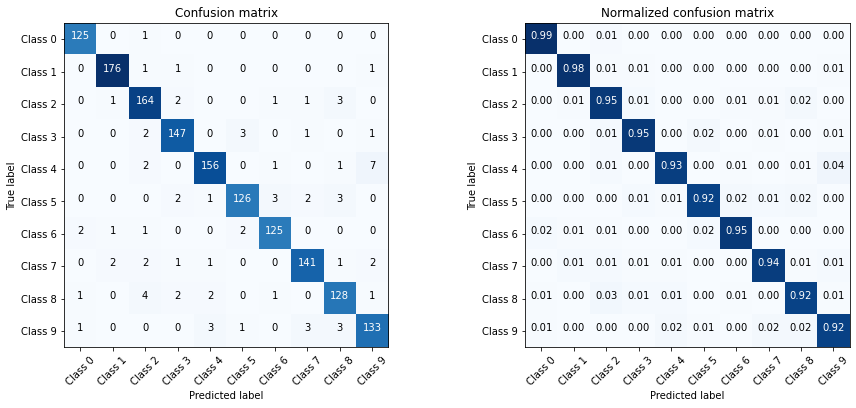

In [22]:
# Define the number of train and test samples you want to use
train_samples_to_use = 35000 #3500  # Max. is 60000
test_samples_to_use = 1500# 1500  # Max. is 10000

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=30, hidden_layer_sizes=(25, 10))
clf_trained = evaluate_classifer(clf,
                                 X_train[0:train_samples_to_use-1, :],
                                 X_test[0:test_samples_to_use-1, :],
                                 y_train[0:train_samples_to_use-1],
                                 y_test[0:test_samples_to_use-1],
                                 class_names,
                                 feature_scale=True)

As we see, the training time increases quite significantly compared to section 2.2.1, even though we just went from 20x20 pixels in the MNIST data we used in exercise 4, to the 28x28 pixels in the full size MNIST data. This signifies one major issue with these methods. Imagine that instead of training on the 28x28 pixels images here, we have FullHD imagery (1920x1080 pixels). As we will see, an issue which we have not discussed yet have also arisen. The classifiers are highly spatially variant. That is, if we were to shift the digits in the image slightly away from the center, the classifier breaks down. We will solve this obstacle next time, and simultaneously improve accuracy, by using convolutional neural networks. 